In [8]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pdb
import os
from pycocotools.coco import COCO
from skimage import io

font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)

In [30]:
src_root = './coco/'
#src_subset = './images/train2017'
src_subset = "C:/Users/atanas.vasev/Desktop/Artifical Inteligence Module/Deep Learning/APDetection/APDetection-main/coco/images/train2017/000000391895.jpg"
#src_file = src_root+'annotations/instances_train2017.json'
src_file = "C:/Users/atanas.vasev/Desktop/Artifical Inteligence Module/Deep Learning/APDetection/APDetection-main/coco/annotations/instances_train2017.json"
src_desc = 'train2017_coco' # a name (identifier) for the dataset

coco_obj = COCO(src_file)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [22]:
# Reading the json file
with open(src_file, 'r') as f:
    root = json.load(f)

root.keys()

dict_keys(['info', 'licenses', 'images', 'annotations', 'categories'])

In [23]:
# Basic High Level Information

n_images = len(root['images'])
n_boxes = len(root['annotations'])
n_categ = len(root['categories'])

# height, width
heights = [x['height'] for x in root['images']]
widths = [x['width'] for x in root['images']]


print('Number of images: ',n_images)
print('Number of bounding boxes: ', n_boxes)
print('Number of classes: ', n_categ)
print('Max min avg height: ', max(heights), min(heights), int(sum(heights)/len(heights)))
print('Max min avg width: ', max(widths), min(widths), int(sum(widths)/len(widths)))

Number of images:  1
Number of bounding boxes:  4
Number of classes:  80
Max min avg height:  360 360 360
Max min avg width:  640 640 640


In [24]:
# Objects per image distribution

img2nboxes = {} # mapping "image id" to "number of boxes"

for ann in root['annotations']:
    img_id = ann['image_id']
    
    if img_id in img2nboxes.keys():
        img2nboxes[img_id] += 1
    else:
        img2nboxes[img_id] = 1

nboxes_list = list(img2nboxes.values())

min_nboxes = min(nboxes_list)
max_nboxes = max(nboxes_list)
avg_nboxes = int(sum(nboxes_list)/len(nboxes_list))

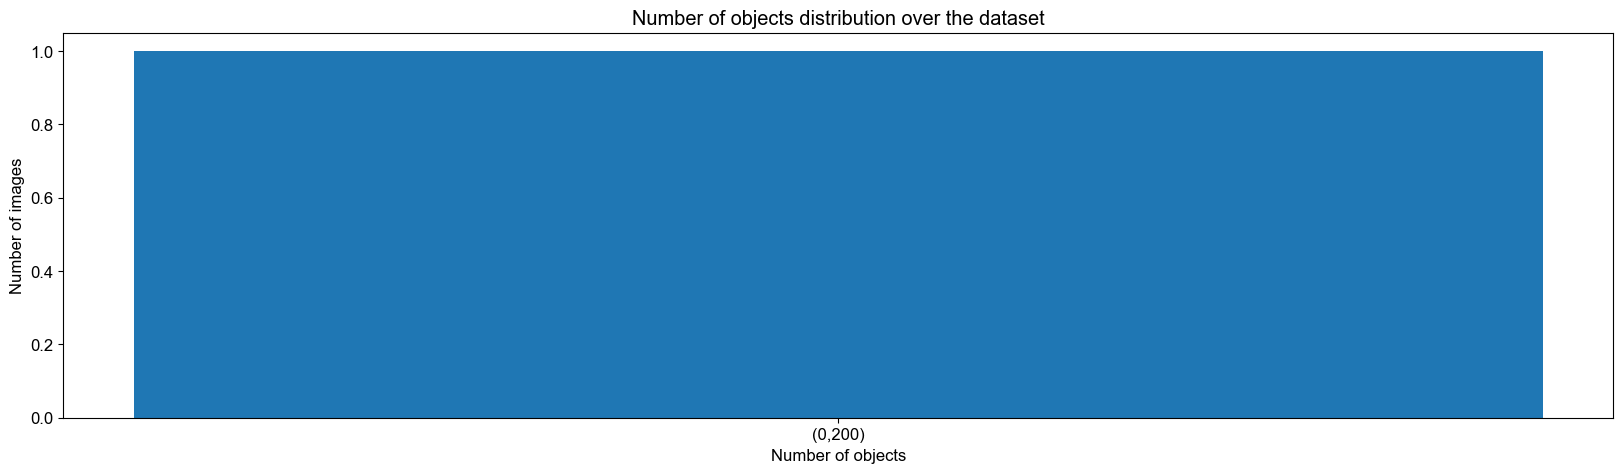

Number of images having atleast one box:  1
Min number of boxes per image:  4
Max number of boxes per image:  4
Avg number of boxes per image:  4


In [25]:
out = pd.cut(nboxes_list, bins=np.arange(0,max_nboxes+200,200), include_lowest=True)

counts = out.value_counts().values
labels = [(int(i.left),int(i.right)) for i in out.value_counts().index.categories]

graph_xind = [i[0] for i in labels] 
ticks = [ '('+str(i[0])+','+ str(i[1])+')' for i in labels]

plt.figure(figsize=(20,5))
plt.bar(graph_xind, counts, tick_label=ticks, width=5)
plt.xlabel('Number of objects')
plt.ylabel('Number of images')
plt.title('Number of objects distribution over the dataset')
plt.show()

print("Number of images having atleast one box: ", len(nboxes_list))
print("Min number of boxes per image: ", min_nboxes)
print("Max number of boxes per image: ", max_nboxes)
print("Avg number of boxes per image: ", avg_nboxes)

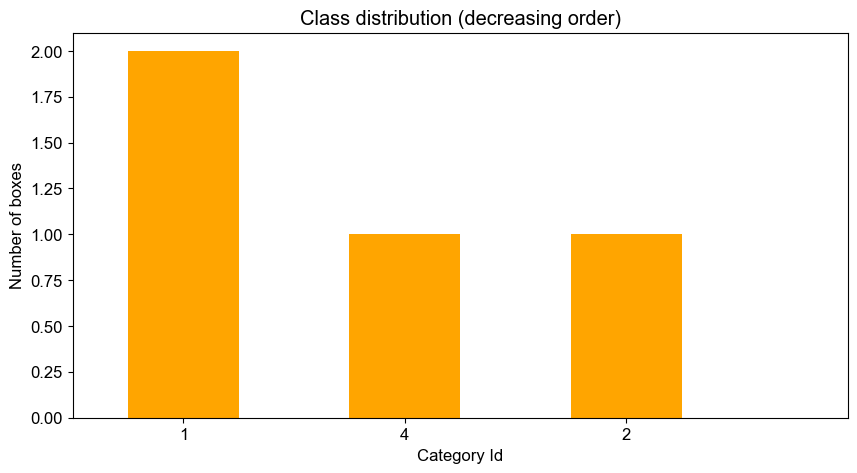

1 -> person, 2 -> bicycle, 3 -> car, 4 -> motorcycle, 5 -> airplane, 6 -> bus, 7 -> train, 8 -> truck, 9 -> boat, 10 -> traffic light, 11 -> fire hydrant, 13 -> stop sign, 14 -> parking meter, 15 -> bench, 16 -> bird, 17 -> cat, 18 -> dog, 19 -> horse, 20 -> sheep, 21 -> cow, 22 -> elephant, 23 -> bear, 24 -> zebra, 25 -> giraffe, 27 -> backpack, 28 -> umbrella, 31 -> handbag, 32 -> tie, 33 -> suitcase, 34 -> frisbee, 35 -> skis, 36 -> snowboard, 37 -> sports ball, 38 -> kite, 39 -> baseball bat, 40 -> baseball glove, 41 -> skateboard, 42 -> surfboard, 43 -> tennis racket, 44 -> bottle, 46 -> wine glass, 47 -> cup, 48 -> fork, 49 -> knife, 50 -> spoon, 51 -> bowl, 52 -> banana, 53 -> apple, 54 -> sandwich, 55 -> orange, 56 -> broccoli, 57 -> carrot, 58 -> hot dog, 59 -> pizza, 60 -> donut, 61 -> cake, 62 -> chair, 63 -> couch, 64 -> potted plant, 65 -> bed, 67 -> dining table, 70 -> toilet, 72 -> tv, 73 -> laptop, 74 -> mouse, 75 -> remote, 76 -> keyboard, 77 -> cell phone, 78 -> micro

In [26]:
# Class distribution
class2nboxes = {} 

for ann in root['annotations']:
    cat_id = ann['category_id']
    
    if cat_id in class2nboxes.keys():
        class2nboxes[cat_id] += 1
    else:
        class2nboxes[cat_id] = 1

sorted_c2nb = [(k,v)for k, v in sorted(class2nboxes.items(), reverse=True, key=lambda item: item[1])]

# top 20 classes
top = min(len(sorted_c2nb),20)

# to plot
y = [i[1] for i in sorted_c2nb[:top]]
x = [i[0] for i in sorted_c2nb[:top]]

plt.figure(figsize=(10,5))
plt.bar(np.arange(len(y)),y, width=0.5,tick_label=x,color='orange')
plt.xlim(-0.5,len(y))
plt.xlabel('Category Id')
plt.ylabel('Number of boxes')
plt.title('Class distribution (decreasing order)')
plt.show()



categ_map = {x['id']: x['name'] for x in root['categories']}
for k in categ_map.keys():
    print(k,'->',categ_map[k], end=", ")

In [27]:
# Class wise bounding box area distribution

bbox_areas = {} # key: class index, value -> a list of bounding box areas

for ann in root['annotations']:
    area = ann['area']
    cat_id = ann['category_id']
    
    if area <= 0.0:
        continue
    
    if cat_id in bbox_areas.keys():
        bbox_areas[cat_id].append(area)
    else:
        bbox_areas[cat_id] = [area]


bbox_avg_areas = []

for cat in bbox_areas.keys():
    areas = bbox_areas[cat]
    avg_area = int(sum(areas)/len(areas))
    
    bbox_avg_areas.append((cat,avg_area))

bbox_avg_areas = sorted(bbox_avg_areas, key = lambda x: x[1])

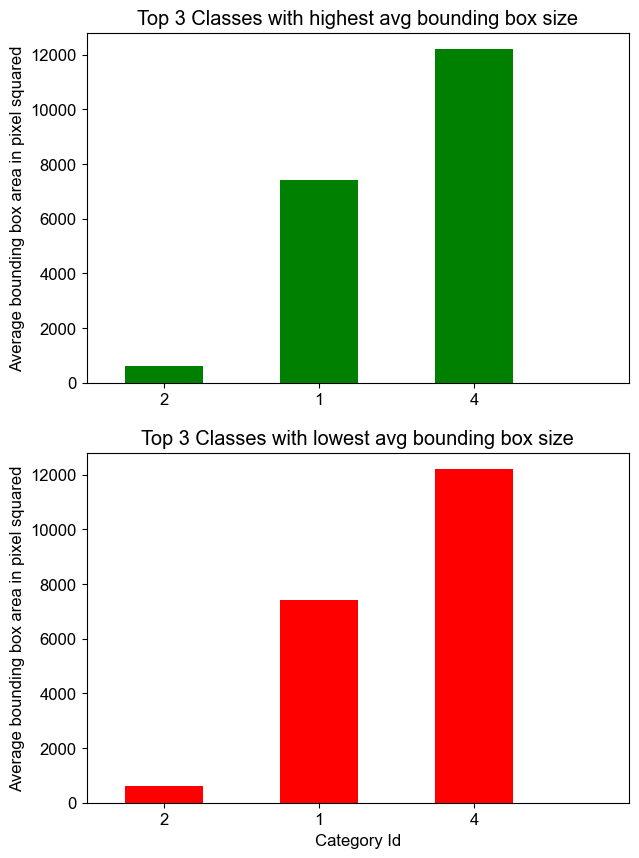

1 -> person, 2 -> bicycle, 3 -> car, 4 -> motorcycle, 5 -> airplane, 6 -> bus, 7 -> train, 8 -> truck, 9 -> boat, 10 -> traffic light, 11 -> fire hydrant, 13 -> stop sign, 14 -> parking meter, 15 -> bench, 16 -> bird, 17 -> cat, 18 -> dog, 19 -> horse, 20 -> sheep, 21 -> cow, 22 -> elephant, 23 -> bear, 24 -> zebra, 25 -> giraffe, 27 -> backpack, 28 -> umbrella, 31 -> handbag, 32 -> tie, 33 -> suitcase, 34 -> frisbee, 35 -> skis, 36 -> snowboard, 37 -> sports ball, 38 -> kite, 39 -> baseball bat, 40 -> baseball glove, 41 -> skateboard, 42 -> surfboard, 43 -> tennis racket, 44 -> bottle, 46 -> wine glass, 47 -> cup, 48 -> fork, 49 -> knife, 50 -> spoon, 51 -> bowl, 52 -> banana, 53 -> apple, 54 -> sandwich, 55 -> orange, 56 -> broccoli, 57 -> carrot, 58 -> hot dog, 59 -> pizza, 60 -> donut, 61 -> cake, 62 -> chair, 63 -> couch, 64 -> potted plant, 65 -> bed, 67 -> dining table, 70 -> toilet, 72 -> tv, 73 -> laptop, 74 -> mouse, 75 -> remote, 76 -> keyboard, 77 -> cell phone, 78 -> micro

In [28]:
top = min(3, len(bbox_avg_areas))

plt.figure(figsize=(7,10))

y = [item[1] for item in bbox_avg_areas[-top:]]
x = [item[0] for item in bbox_avg_areas[-top:]]

y2 = [item[1] for item in bbox_avg_areas[:top]]
x2 = [item[0] for item in bbox_avg_areas[:top]]

plt.subplot(211)
plt.bar(np.arange(len(y)),y, width=0.5,tick_label=x,color='green')
plt.xlim(-0.5,len(y))
# plt.xlabel('Category Id')
plt.ylabel('Average bounding box area in pixel squared')
plt.title('Top '+str(top)+' Classes with highest avg bounding box size')


plt.subplot(212)
plt.bar(np.arange(len(y2)),y2, width=0.5,tick_label=x2,color='red')
plt.xlim(-0.5,len(y2))
plt.xlabel('Category Id')
plt.ylabel('Average bounding box area in pixel squared')
plt.title('Top '+str(top)+' Classes with lowest avg bounding box size')
plt.show()




categ_map = {x['id']: x['name'] for x in root['categories']}
for k in categ_map.keys():
    print(k,'->',categ_map[k], end=", ")

['motorcycle', 'person', 'person', 'bicycle']


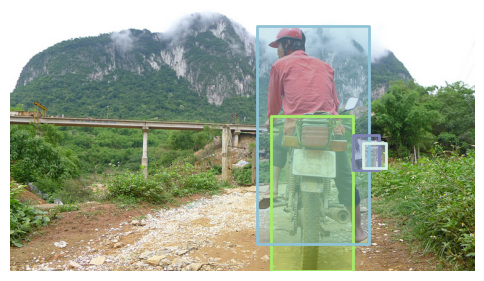

In [33]:
# generate a random image
imgIds = [i['id'] for i in root['images']]
catIds = [i['id'] for i in root['categories']]
img = coco_obj.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]
#img_path= os.path.join(src_root, src_subset, img['file_name'])
img_path= os.path.join(src_subset)
I = io.imread(img_path)

# plot annotations
plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(I)
annIds = coco_obj.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco_obj.loadAnns(annIds)

#  disable segmentation
for a in anns:
    if 'segmentation' in a.keys():
        a['segmentation'] = []
coco_obj.showAnns(anns, draw_bbox=True)
classes = [categ_map[a['category_id']] for a in anns]
print(classes)